In [35]:
import requests
import lxml
import pandas as pd
from bs4 import BeautifulSoup, SoupStrainer
from sklearn.preprocessing import MultiLabelBinarizer
import re
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def load_to_csv(df: pd.DataFrame, file_name: str):
    df.to_csv(file_name, index=False)

In [4]:
def load_dataset(file_name: str):
    return pd.read_csv(file_name)

In [73]:
def fix_genres_developers(df: pd.DataFrame):
    for index in df.index:
        if ',' in df.loc[index, 'Genres']:
            temp = df.loc[index, 'Genres'].split(',')
            df.loc[index, 'Genres'] = temp[0]
        if ',' in df.loc[index, 'Developer']:
            temp = df.loc[index, 'Developer'].split(',')
            df.loc[index, 'Developer'] = temp[0]
            

In [5]:
def ranges_splitter(ranges):
    ranges = ranges.replace(" ","")
    min, max = ranges.split('..')
    return min.replace(",", ""), max.replace(",", "")

In [5]:
def get_data_from_steam(steam_store_link: str, s: requests.Session):
    only_p = SoupStrainer('div', attrs={"id": "userReviews"})
    request = s.get(steam_store_link)
    while request.status_code != 200:
        request = s.get(steam_store_link)
    soup = BeautifulSoup(request.content, 'lxml', parse_only=only_p)
    summary_columns = soup("div", attrs={"class": "summary column"})
    if len(summary_columns) == 1:
        s = summary_columns[0].get_text()
        if " ".join(s.split()) == 'No user reviews':
            return False
        if 'Need more user reviews to generate a score' in  " ".join(s.split()):
            return False
        spans = summary_columns[0].findAll("span")
    else:
        spans = summary_columns[1].findAll("span")
    
    temp = spans[1].get_text()
    temp = re.findall(r"[\d']+", temp)
    max_reviewers = int(''.join(temp))
    if len(spans) == 3:
        review_perc = int(spans[2].get_text().replace(" ", "").split('%')[0].split('-')[1])
    else:
        review_perc = 0
    
    return review_perc, max_reviewers

In [6]:
def get_data_from_steamspy_game_page(app_id: str, s: requests.Session):
    url = f"https://steamspy.com/{app_id}"
    only_p = SoupStrainer('div', attrs={"class": "panel-body"})
    genre_num = 0
    genres = ''
    request = s.get(url)
    soup = BeautifulSoup(request.content, 'lxml', parse_only=only_p)
    p = soup("p")[0]
    only_a = p.findAll("a")
    for element in only_a:
        if '/tag/Software' in element['href']: #detects if a game is a software
            return False #not a game
        
        if element.get_text() == 'Store':
             steam_store_link = element['href']
             result = get_data_from_steam(steam_store_link, s)
             if result == False:
                 return False
             else:
                 review_perc, max_reviewers = result
        
        if '/genre/' in element['href']:
            if genre_num == 0:
                genres += element.get_text()
                genre_num += 1
            else:
                genres += ',' + element.get_text()
    return genres, review_perc, max_reviewers

In [7]:
def get_data_from_steamspy_into_dataframe(years: list):
    s = requests.Session()
    game_names = list()
    developer = list()
    minimum_owners = list()
    maximum_owners = list()
    prices = list()
    genres_list = list()
    review_percs = list()
    max_reviewers_list = list()
    years_list = list()
    exceptions = ['EA Play', 'Office Simulator', 'Steam Deck', 'Steam Deck Deposit']
    for year in years:
        url = f"https://steamspy.com/year/{year}"
        request = s.get(url)
        only_the_table = SoupStrainer("table")
        soup = BeautifulSoup(request.content, 'lxml', parse_only=only_the_table)
        tbl = soup("table", attrs={"class": "table"})[0]
        for row in tbl("tr"):
            cells = row("td")
            if len(cells) > 0:
                game_name = " ".join(cells[1].a.get_text().split())
                print(game_name)
                if game_name in exceptions:
                    continue
                result = get_data_from_steamspy_game_page(cells[1].a['href'], s)
                if result == False:
                    continue
                else:
                    genres, review_perc, max_reviewers = result
                price = cells[3].get_text()
                if price == 'N/A':
                    continue
                elif price == 'Free':
                    price = 0
                    prices.append(price)
                else:
                    price = price.split('$')[1]
                    prices.append(float(price))
                game_names.append(game_name)
                developer.append(cells[7].get_text())
                min, max = ranges_splitter(cells[5].get_text())
                minimum_owners.append(int(min))
                maximum_owners.append(int(max))
                genres_list.append(genres)
                review_percs.append(float(review_perc / 100))
                max_reviewers_list.append(max_reviewers)
                years_list.append(year)
    
    df = pd.DataFrame({'Game Name': game_names,
                        'Developer': developer,
                        'Release year': years_list,
                        'Price': prices,
                        'Genres': genres_list,
                        'Review %': review_percs,
                        'Max Reviewers': max_reviewers_list,
                        'Minimum Owners': minimum_owners,
                        'Maximum Owners': maximum_owners})
    return df


In [ ]:
df = get_data_from_steamspy_into_dataframe([2021, 2020, 2019])
load_to_csv(df, 'full_dataset.csv')

In [6]:
df = load_dataset('./full_dataset.csv')
df

,Game Name,Developer,Release year,Price,Genres,Review %,Max Reviewers,Minimum Owners,Maximum Owners
0,Chicory: A Colorful Tale,"Greg Lobanov, Alexis Dean-Jones, Lena Raine, M...",2021,15.99,"Adventure,Indie,RPG",0.98,976,0,20000
1,Psychonauts 2,Double Fine Productions,2021,38.99,"Action,Adventure",0.98,4756,100000,200000
2,Lacuna – A Sci-Fi Noir Adventure,DigiTales Interactive,2021,9.59,"Adventure,Indie",0.94,603,200000,500000
3,OPUS: Echo of Starsong,SIGONO INC.,2021,13.49,"Adventure,Indie",0.97,3135,50000,100000
4,It Takes Two,Hazelight,2021,19.99,"Action,Adventure",0.96,54033,2000000,5000000
...,...,...,...,...,...,...,...,...,...
13560,PC Building Simulator,"Claudiu Kiss, The Irregular Corporation",2019,7.99,"Indie,Simulation",0.94,32567,1000000,2000000
13561,Muse Dash,peropero,2019,1.49,"Action,Casual,Indie",0.00,49942,1000000,2000000
13562,People Playground,mestiez,2019,1.99,"Action,Casual,Indie,Simulation",0.98,76495,2000000,5000000
13563,Space Engineers,Keen Software House,2019,13.99,"Action,Indie,Simulation,Strategy,in Early Access",0.89,79661,2000000,5000000


In [8]:
load_to_csv(df.dropna(), 'dataset_no_nan.csv')

In [12]:
df_no_nan = load_dataset('./dataset_no_nan.csv')
df_no_nan

,Game Name,Developer,Release year,Price,Genres,Review %,Max Reviewers,Minimum Owners,Maximum Owners
0,Chicory: A Colorful Tale,"Greg Lobanov, Alexis Dean-Jones, Lena Raine, M...",2021,15.99,"Adventure,Indie,RPG",0.98,976,0,20000
1,Psychonauts 2,Double Fine Productions,2021,38.99,"Action,Adventure",0.98,4756,100000,200000
2,Lacuna – A Sci-Fi Noir Adventure,DigiTales Interactive,2021,9.59,"Adventure,Indie",0.94,603,200000,500000
3,OPUS: Echo of Starsong,SIGONO INC.,2021,13.49,"Adventure,Indie",0.97,3135,50000,100000
4,It Takes Two,Hazelight,2021,19.99,"Action,Adventure",0.96,54033,2000000,5000000
...,...,...,...,...,...,...,...,...,...
13548,PC Building Simulator,"Claudiu Kiss, The Irregular Corporation",2019,7.99,"Indie,Simulation",0.94,32567,1000000,2000000
13549,Muse Dash,peropero,2019,1.49,"Action,Casual,Indie",0.00,49942,1000000,2000000
13550,People Playground,mestiez,2019,1.99,"Action,Casual,Indie,Simulation",0.98,76495,2000000,5000000
13551,Space Engineers,Keen Software House,2019,13.99,"Action,Indie,Simulation,Strategy,in Early Access",0.89,79661,2000000,5000000


In [59]:
df_no_nan['Maximum Owners'].corr(df_no_nan['Max Reviewers'], method='pearson') # checking if there is correlation between Maximum Owners and Max Reviewers

0.8665487006978339

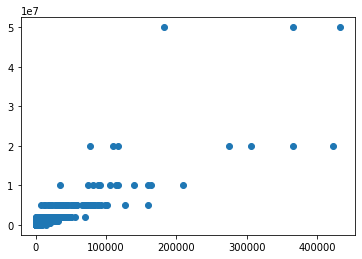

In [56]:
ct1 = pd.crosstab(df_no_nan['Maximum Owners'], df_no_nan['Max Reviewers'])
plt.scatter(df_no_nan['Max Reviewers'], df_no_nan['Maximum Owners'])

In [74]:
df_fixed_genres_developers = df_no_nan.copy()
fix_genres_developers(df_fixed_genres_developers)

In [76]:
load_to_csv(df_fixed_genres_developers, 'dataset_fixed_genres_developers')
df_fixed_genres_developers

,Game Name,Developer,Release year,Price,Genres,Review %,Max Reviewers,Minimum Owners,Maximum Owners
0,Chicory: A Colorful Tale,Greg Lobanov,2021,15.99,Adventure,0.98,976,0,20000
1,Psychonauts 2,Double Fine Productions,2021,38.99,Action,0.98,4756,100000,200000
2,Lacuna – A Sci-Fi Noir Adventure,DigiTales Interactive,2021,9.59,Adventure,0.94,603,200000,500000
3,OPUS: Echo of Starsong,SIGONO INC.,2021,13.49,Adventure,0.97,3135,50000,100000
4,It Takes Two,Hazelight,2021,19.99,Action,0.96,54033,2000000,5000000
...,...,...,...,...,...,...,...,...,...
13548,PC Building Simulator,Claudiu Kiss,2019,7.99,Indie,0.94,32567,1000000,2000000
13549,Muse Dash,peropero,2019,1.49,Action,0.00,49942,1000000,2000000
13550,People Playground,mestiez,2019,1.99,Action,0.98,76495,2000000,5000000
13551,Space Engineers,Keen Software House,2019,13.99,Action,0.89,79661,2000000,5000000
